In [1]:
from watclaimdata import test_df,train_df,valid_df

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import pandas as pd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

2023-10-22 00:01:27.806572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
train_df.head()

,claim,id,rating,original_rating
0,OpIndia claimed Greta Thunberg's real name is ...,1,0,false
1,"“38,000 prisoners were released from federal p...",2,1,misleading
2,Says Wisconsin ‘could compel’ Foxconn to insta...,3,1,barely-true
3,A 4-year-old boy was accused of hacking the FB...,4,0,false
4,Whistleblower accusing Philippine VP of fraud ...,5,1,misleading


In [29]:
train_df['rating'].unique()

array([0, 1, 2])

In [34]:
train_df[train_df['rating'] == 0][:5]

,claim,id,rating,original_rating
0,OpIndia claimed Greta Thunberg's real name is ...,1,0,false
3,A 4-year-old boy was accused of hacking the FB...,4,0,false
5,"A video shows Muslims ""marching for Sharia law...",6,0,false
10,New York State Gov. Andrew Cuomo issued a mult...,11,0,false
11,"Vanilla ice cream was originally a deep, dark ...",12,0,false


In [35]:
train_df[train_df['rating'] == 1][:5]

,claim,id,rating,original_rating
1,"“38,000 prisoners were released from federal p...",2,1,misleading
2,Says Wisconsin ‘could compel’ Foxconn to insta...,3,1,barely-true
4,Whistleblower accusing Philippine VP of fraud ...,5,1,misleading
6,These photos show a victim and his assailants ...,7,1,misleading
7,"Says Scott Walker ""said he wouldn't touch"" the...",8,1,barely-true


In [31]:
train_df[train_df['rating'] == 2][:5]

,claim,id,rating,original_rating
13,"Says that U.S. Rep. Allen West is ""a constitue...",14,2,true
14,"""The average margin of victory in the House of...",15,2,true
25,"""Not a single Democrat opposed Neil Gorsuch's ...",26,2,true
28,"Ted Livingston, the CEO of Kik Interactive, an...",29,2,true
31,There are cities and counties in Georgia that ...,32,2,true


In [49]:
train_df['new_rating'] = np.where(train_df['rating'] == 0,'false',np.where(train_df['rating'] == 1,'misleading',np.where(train_df['rating'] == 2,'true','')))
train_df['new_rating'].unique()

test_df['new_rating'] = np.where(test_df['rating'] == 0,'false',np.where(test_df['rating'] == 1,'misleading',np.where(test_df['rating'] == 2,'true','')))
valid_df['new_rating'] = np.where(valid_df['rating'] == 0,'false',np.where(valid_df['rating'] == 1,'misleading',np.where(valid_df['rating'] == 2,'true','')))



In [50]:

dummy_train_y = np.array(pd.get_dummies(train_df['new_rating']))
dummy_test_y = np.array(pd.get_dummies(test_df['new_rating']))
dummy_valid_y = np.array(pd.get_dummies(valid_df['new_rating']))


In [2]:
nltk.download('word2vec_sample')
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

EMBEDDING_DIM = len(model['university'])      

# initialize embedding matrix and word-to-id map:  
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))  
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

[nltk_data] Downloading package word2vec_sample to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!


In [4]:
train_df['claim'].values.tolist()[:4]

["OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
 '“38,000 prisoners were released from federal prison” during the Obama administration.',
 'Says\xa0Wisconsin ‘could compel’ Foxconn to install solar panels that would power 33,000 homes.',
 "A 4-year-old boy was accused of hacking the FBI's databases."]

In [7]:
np.array(train_df['rating'].values.tolist())[:4]

array([0, 1, 1, 0])

In [9]:
train_examples = train_df['claim'].values.tolist()
train_examples = tf.convert_to_tensor(train_examples)
train_labels = np.array(train_df['rating'].values.tolist())
test_examples = test_df['claim'].values.tolist()
test_examples = tf.convert_to_tensor(test_examples)
test_labels = np.array(test_df['rating'].values.tolist())
val_examples = valid_df['claim'].values.tolist()
val_examples = tf.convert_to_tensor(val_examples)
val_labels = np.array(valid_df['rating'].values.tolist())

# print('Train data contains {} with labels of {}'.format(train_examples.shape[0],train_labels['rating'].unique()))

In [10]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"OpIndia claimed Greta Thunberg's real name is Ghazala bhat",
       b'\xe2\x80\x9c38,000 prisoners were released from federal prison\xe2\x80\x9d during the Obama administration.',
       b'Says\xc2\xa0Wisconsin \xe2\x80\x98could compel\xe2\x80\x99 Foxconn to install solar panels that would power 33,000 homes.',
       b"A 4-year-old boy was accused of hacking the FBI's databases."],
      dtype=object)>

In [11]:
train_labels[:4]

array([0, 1, 1, 0])

In [25]:
train_labels.shape

(26976,)

In [47]:
# tf.convert_to_tensor(train_examples)

In [12]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

In [13]:
train_tokens[0]

<tf.Tensor: shape=(9,), dtype=string, numpy=
array([b'OpIndia', b'claimed', b'Greta', b"Thunberg's", b'real', b'name',
       b'is', b'Ghazala', b'bhat'], dtype=object)>

In [14]:
MAX_SEQUENCE_LENGTH = 128

def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

In [15]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Examples processed:  20000
Examples processed:  25000
Total examples:  26975
Examples processed:  0
Total examples:  3372


In [17]:
train_input[:4]

array([[43981, 37588, 43981, 43981, 14926, 10804, 16908, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [18]:
train_labels[:4]

array([0, 1, 1, 0])

In [62]:
def build_ann_model(num_classes, embeddings_trainable=False):
    an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    
    an_embedding_layer = Embedding(embedding_matrix.shape[0],
                                   embedding_matrix.shape[1],
                                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                   input_length=MAX_SEQUENCE_LENGTH,
                                   trainable=embeddings_trainable)
    
    an_embeddings = an_embedding_layer(an_input_layer)
    
    an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)
    
    an_classification = tf.keras.layers.Dense(num_classes, 
                                              activation='softmax', 
                                              name='an_classification')(an_avg_embeddings)
    
    an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])
    
    
    an_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        amsgrad=False,
                                                        name='Adam'),
                     metrics='accuracy')
    return an_model

In [64]:
ann_model = build_ann_model(3)
ann_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 3)                 903       
                                                                 
Total params: 13195503 (50.34 MB)
Trainable params: 903 (3.53 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________


In [65]:
ann_history = ann_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_test_y),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9971 - accuracy: 0.5098 - val_loss: 0.9598 - val_accuracy: 0.5574
Epoch 2/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9503 - accuracy: 0.5535 - val_loss: 0.9461 - val_accuracy: 0.5500
Epoch 3/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9406 - accuracy: 0.5541 - val_loss: 0.9379 - val_accuracy: 0.5553
Epoch 4/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9343 - accuracy: 0.5544 - val_loss: 0.9321 - val_accuracy: 0.5562
Epoch 5/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9295 - accuracy: 0.5555 - val_loss: 0.9275 - val_accuracy: 0.5606
Epoch 6/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9256 - accuracy: 0.5568 - val_loss: 0.9237 - val_accuracy: 0.5597
Epoch 7/20
843/843 [==============================] - 2s 2ms/step - loss: 0.9224 - accuracy: 0.5590 - val_loss: 0.9205 - val_accuracy: 0.5603
Epoch 

In [66]:
def build_dan_model(num_classes, hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)
    
    dan_classification = tf.keras.layers.Dense(3,
                                               activation='softmax',
                                               name='dan_classification')(last_hidden_output)
    
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

python(69056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(69058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


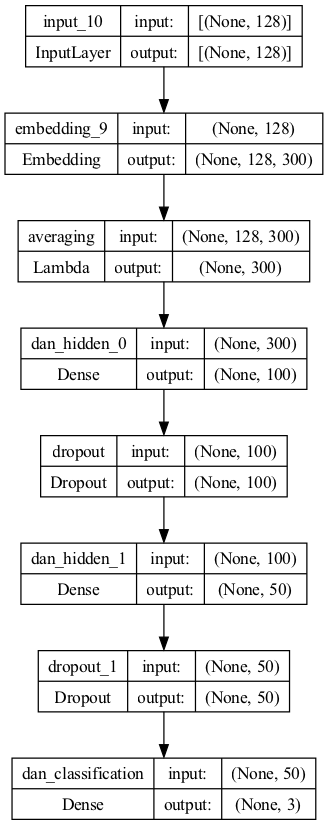

In [67]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5
num_classes = 3

dan_model = build_dan_model(num_classes, hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [68]:
dan_history = dan_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_test_y),
                          batch_size=32,
                          epochs=20
                            )

Epoch 1/20
843/843 [==============================] - 3s 3ms/step - loss: 0.9457 - accuracy: 0.5194 - val_loss: 0.9049 - val_accuracy: 0.5680
Epoch 2/20
843/843 [==============================] - 2s 3ms/step - loss: 0.9065 - accuracy: 0.5664 - val_loss: 0.8857 - val_accuracy: 0.5835
Epoch 3/20
843/843 [==============================] - 3s 3ms/step - loss: 0.8938 - accuracy: 0.5813 - val_loss: 0.8818 - val_accuracy: 0.5838
Epoch 4/20
843/843 [==============================] - 3s 4ms/step - loss: 0.8856 - accuracy: 0.5844 - val_loss: 0.8756 - val_accuracy: 0.5888
Epoch 5/20
843/843 [==============================] - 3s 3ms/step - loss: 0.8803 - accuracy: 0.5894 - val_loss: 0.8717 - val_accuracy: 0.5909
Epoch 6/20
843/843 [==============================] - 3s 4ms/step - loss: 0.8789 - accuracy: 0.5882 - val_loss: 0.8694 - val_accuracy: 0.5888
Epoch 7/20
843/843 [==============================] - 2s 3ms/step - loss: 0.8773 - accuracy: 0.5901 - val_loss: 0.8694 - val_accuracy: 0.5909
Epoch 

In [70]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

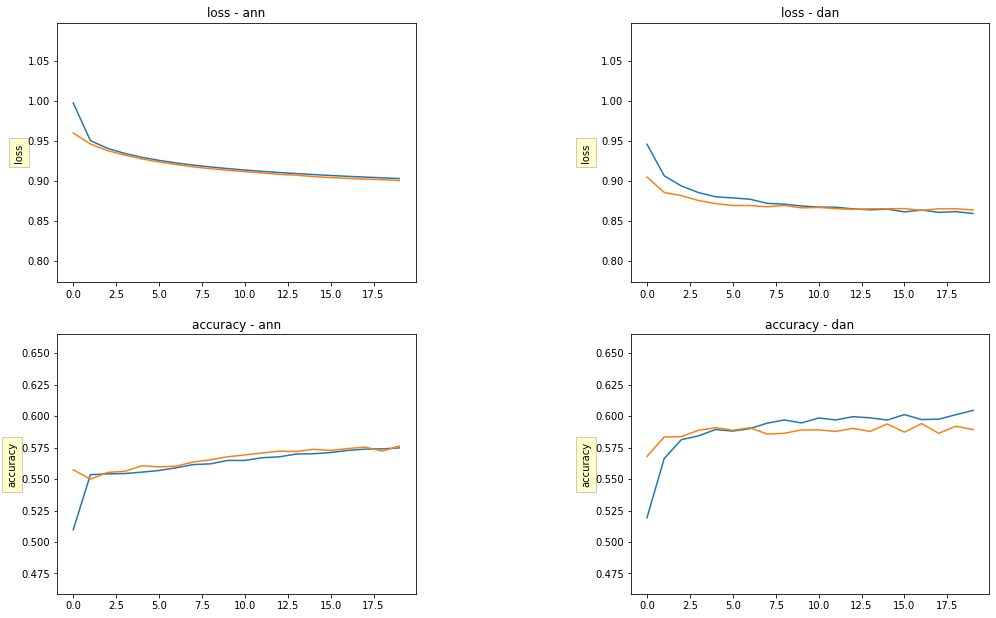

In [71]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          ann_history,
          dan_history,
          model_1_name='ann',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

# CNN

In [72]:
def build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(3, activation='softmax')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [73]:
# Now specify model hyperparameters and call the function to create a CNN model

num_classes = 3
num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_classes, num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [74]:
cnn_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 128, 300)             1319460   ['input_11[0][0]']            
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 126, 100)             90100     ['embedding_10[0][0]']        
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 100)             120100    ['embedding_10[0][0]'] 

In [ ]:
cnn_history = cnn_model.fit(train_input,
                          dummy_train_y,
                          validation_data=(test_input, dummy_test_y),
                          batch_size=32,
                          epochs=5
                            )

Epoch 1/5
843/843 [==============================] - 61s 71ms/step - loss: 0.8972 - accuracy: 0.5740 - val_loss: 0.8689 - val_accuracy: 0.5932
Epoch 2/5
843/843 [==============================] - 63s 74ms/step - loss: 0.8495 - accuracy: 0.6055 - val_loss: 0.8701 - val_accuracy: 0.5840
Epoch 3/5
843/843 [==============================] - 62s 74ms/step - loss: 0.8130 - accuracy: 0.6251 - val_loss: 0.8533 - val_accuracy: 0.6036
Epoch 4/5
843/843 [==============================] - 57s 68ms/step - loss: 0.7657 - accuracy: 0.6495 - val_loss: 0.8642 - val_accuracy: 0.5992
Epoch 5/5
573/843 [===================>..........] - ETA: 17s - loss: 0.7089 - accuracy: 0.6797

# RNN